# Model

In [1]:
import numpy as np
import torch
import torchvision.transforms.functional
from torch import nn

In [2]:
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.first = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.second = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.first(x)
        x = self.act1(x)
        x = self.second(x)
        x = self.act2(x)
        return x

In [3]:
class DownSample(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x: torch.Tensor):
        return self.pool(x)

In [4]:
class UpSample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor):
        return self.up(x)

In [22]:
class CropAndConcat(nn.Module):
    def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
        contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[-2], x.shape[-1]])
        x = torch.cat([x, contracting_x], dim=1)
        return x

In [39]:
class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = nn.ModuleList(
            [DoubleConvolution(i, o) for i, o in [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
        self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
        self.middle_conv = DoubleConvolution(512, 1024)
        self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.up_conv = nn.ModuleList(
            [DoubleConvolution(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
        self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
        pass_through = []
        for i in range(len(self.down_conv)):
            x = self.down_conv[i](x)
            pass_through.append(x)
            x = self.down_sample[i](x)
        x = self.middle_conv(x)
        for i in range(len(self.up_conv)):
            x = self.up_sample[i](x)
            x = self.concat[i](x, pass_through.pop())
            x = self.up_conv[i](x)
        x = self.final_conv(x)
        return x

# Data Processing

In [7]:
import os
import pandas as pd
import pydicom as dicom
import nibabel as nib

from pathlib import Path, PureWindowsPath
from torch.utils.data import Dataset

In [30]:
class PancreasCTDataset(Dataset):
    def __init__(self, annotation_file, img_dir_path, target_dir_path, transform=None, target_transform=None):
        self.sample = self.make_dataset(annotation_file, img_dir_path, target_dir_path)
        self.img_dir_path = img_dir_path
        self.target_dir_path = target_dir_path
        self.transform = transform
        self.target_transform = target_transform

    @staticmethod
    def make_dataset(annotation_file, img_dir_path, target_dir_path):
        dataset = []
        pancreas_location = pd.read_csv(annotation_file)[['Subject ID', 'File Location']].to_numpy()
        for pancreas_name, pancreas_path in pancreas_location:
            target_filename = 'label' + pancreas_name[-4:] + '.nii.gz'
            target_path = os.path.join(target_dir_path, target_filename)
            pancreas_path = PureWindowsPath(pancreas_path)
            pancreas_path = os.path.join(img_dir_path, pancreas_path.as_posix())
            pancreas_slice_filename = os.listdir(pancreas_path)
            pancreas_slice_filename.sort()
            for layer, filename in enumerate(pancreas_slice_filename):
                pancreas_slice_path = os.path.join(pancreas_path, filename)
                dataset.append((pancreas_slice_path, (target_path, layer)))
        return dataset

    def __len__(self):
        return len(self.sample)

    def __getitem__(self, idx):
        pancreas_slice_path, target_slice_path = self.sample[idx]
        slice = (dicom.dcmread(pancreas_slice_path).pixel_array).astype(np.float32)
        target = np.moveaxis(nib.load(target_slice_path[0]).get_fdata(), -1, 0)[target_slice_path[1]]
        if self.transform:
            slice = self.transform(slice)
        if self.target_transform:
            target = self.target_transform(target)
        return slice, target

# Training

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [28]:
annotation_file = Path('/home/ceduardosq/Code/ArtificialIntelligence/P/5/Data/metadata.csv')
img_dir_path = Path('/home/ceduardosq/Code/ArtificialIntelligence/P/5/Data/')
target_dir_path = Path('/home/ceduardosq/Code/ArtificialIntelligence/P/5/Data/Pancreas-Labels/')

transform = torchvision.transforms.Compose([torchvision.transforms.PILToTensor()])

dataset = PancreasCTDataset(annotation_file=annotation_file, img_dir_path=img_dir_path, target_dir_path=target_dir_path)

trainset, valset, testset = torch.utils.data.random_split(dataset=dataset, lengths=[0.7, 0.2, 0.1],
                                                          generator=torch.Generator().manual_seed(42))

batch_size = 1

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [11]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 512, 512])


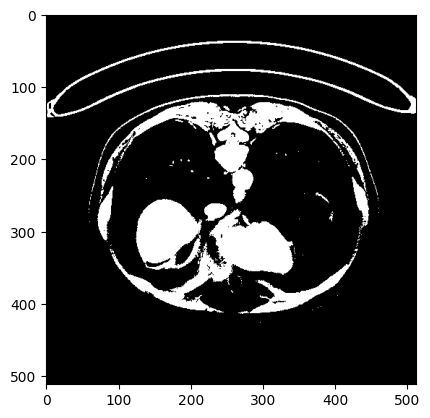

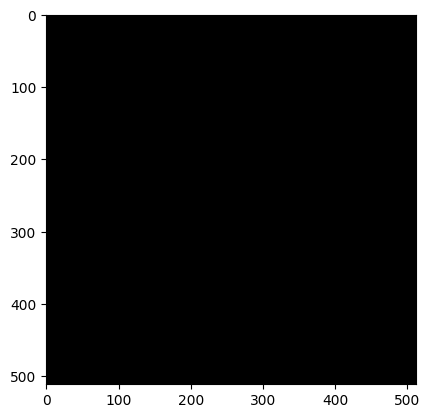

In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=plt.cm.bone)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(labels))

In [40]:
model = UNet(in_channels=1, out_channels=1).to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
torch.Size([512, 64, 64])
torch.Size([512, 128, 64])


RuntimeError: Given groups=1, weight of size [512, 1024, 3, 3], expected input[1, 512, 128, 64] to have 1024 channels, but got 512 channels instead